In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

'for estimating the SNR of the LR test (binary hypotheses) of the generated signal with the simulated LIGO noise------------'


# Load the data of LIGO noise PSD from the text file
data = np.loadtxt('.\data\iLIGOSensitivity.txt')

# Extract the sampling times and data values from the data
frequency = data[:, 0]
sqrt_psd = data[:, 1]

## Modify the ASD to be constant below 50 Hz and linearly decrease to zero from 700 Hz to the Nyquist frequency
for i in range(len(sqrt_psd)):
    if frequency[i] >= 50:
        index_f50= i
        break
for i in range(len(sqrt_psd) - 1, -1, -1): 
    if frequency[i] <= 700:
        index_f700 = i
        break
interval=sqrt_psd[index_f700]/(len(sqrt_psd)-1- index_f700)
m=0
for i in range(len(sqrt_psd)):
    if frequency[i] <= 50:
        sqrt_psd[i] = sqrt_psd[index_f50]
    elif frequency[i] >= 700:
        m=m+1
        sqrt_psd[i] = sqrt_psd[index_f700]- interval * m
frequency = np.concatenate(([0], frequency))
sqrt_psd = np.concatenate(([sqrt_psd[0]], sqrt_psd))

## convert irregularly spaced frequencies into the required DFT frequencies using linear interpolation
from scipy.interpolate import interp1d
n_samples = 16384*2
samp_freq = 16384
interp_func = interp1d(frequency , sqrt_psd, kind='linear', bounds_error=False, fill_value="extrapolate")
dft_freqs = np.fft.rfftfreq(n_samples, d=1/samp_freq)
psd_interp = interp_func(dft_freqs)
frequency = dft_freqs
sqrt_psd = psd_interp

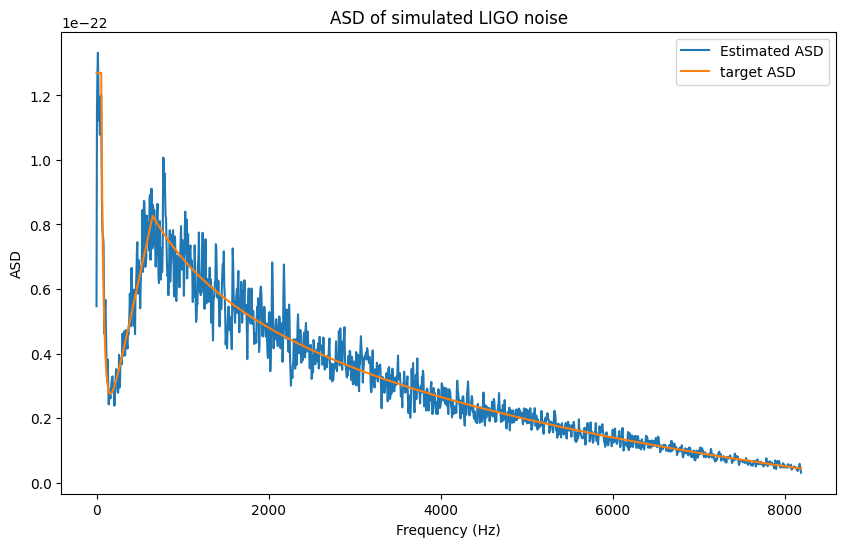

In [8]:
from function import statgaussnoisegen
## Generate a LIGO noise realization using the modified ASD
noise_ligo = statgaussnoisegen(n_samples,np.column_stack([frequency, sqrt_psd**2 ]),500, samp_freq)

# Estimate the PSD using Welch's method to verify the ASD of the generated noise
f_welch, psd_welch = signal.welch(noise_ligo, samp_freq, nperseg=3000)

# Plot the estimated ASD
plt.figure(figsize=(10, 6))
plt.plot(f_welch, np.sqrt(psd_welch/2),label='Estimated ASD')
plt.plot(frequency,sqrt_psd, label='target ASD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.title('ASD of simulated LIGO noise')
plt.legend() 
plt.show()

Theoretical SNR: 50
estimating the SNR using the LR test from multiple data realizations: 50.83
Barry's SNR calculation: 52.17
Clara's SNR calculation: 51.18


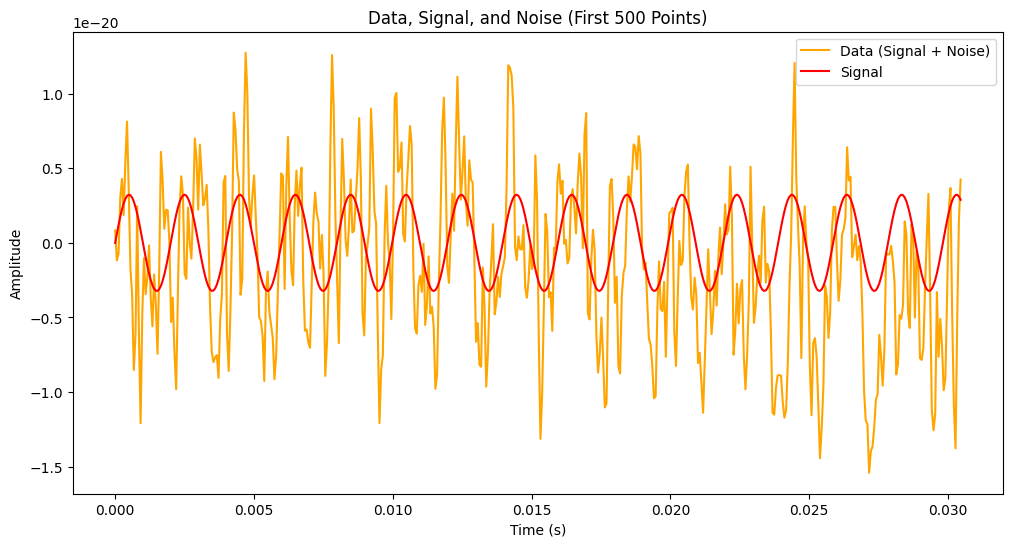

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import signal

from function import crcbgenqcsig, statgaussnoisegen, innerprod_psd, snr_calculation

## for estimating the SNR of the LR test (binary hypotheses) from multiple data realizations

# Target SNR for the LR
snr = 50

# Data generation parameters
time_vec = np.arange(n_samples) / samp_freq

# Generate the signal that is to be normalized
a1, a2, a3 = 500, 100, 90
A = 1  # Amplitude value does not matter as it will be changed in normalization
sig_vec = crcbgenqcsig(time_vec, A, [a1, a2, a3])

# Generate the PSD vector for normalization
pos_freq = frequency
psd_pos_freq=sqrt_psd**2  # PSD is the square of the ASD
# print('psd_pos_freq shape:', psd_pos_freq.shape)

# Calculation of the norm
# Norm of signal squared is inner product of signal with itself
norm_sig_sqrd = innerprod_psd(sig_vec, sig_vec, samp_freq, psd_pos_freq)

# Normalize signal to specified SNR
sig_vec = snr * sig_vec / np.sqrt(norm_sig_sqrd)

# Test: Obtain LLR values for multiple noise realizations (H0)
n_h0_data = 1000
llr_h0 = np.zeros(n_h0_data)

for lp in range(n_h0_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 500, samp_freq)
    llr_h0[lp] = innerprod_psd(noise_vec, sig_vec, samp_freq, psd_pos_freq)

# Obtain LLR for multiple data (signal + noise) realizations (H1)
n_h1_data = 1000
llr_h1 = np.zeros(n_h1_data)

for lp in range(n_h1_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 500, samp_freq)
    # Add normalized signal
    data_vec = noise_vec + sig_vec
    llr_h1[lp] = innerprod_psd(data_vec, sig_vec, samp_freq, psd_pos_freq)

# Signal to noise ratio estimate
est_snr = (np.mean(llr_h1) - np.mean(llr_h0)) / np.std(llr_h0)

snr_clara = snr_calculation(data_vec, sig_vec, f_welch, psd_welch/2,samp_freq )
from modified_barrySNR import calculate_snr
snr_barry = calculate_snr(data_vec, sig_vec/snr, psd_welch/2, df=1/samp_freq, freq_range=None, domain='time')

print(f"Theoretical SNR: {snr}")
print(f"estimating the SNR using the LR test from multiple data realizations: {est_snr:.2f}")
print(f"Barry's SNR calculation: {snr_barry:.2f}")
print(f"Clara's SNR calculation: {snr_clara:.2f}")

#plot data and pure signal with 500 points
plt.figure(figsize=(12, 6))
plt.plot(time_vec[:500], data_vec[:500], label='Data (Signal + Noise)', color='orange')
plt.plot(time_vec[:500], sig_vec[:500], label='Signal', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Data, Signal, and Noise (First 500 Points)')
plt.legend()
plt.show()  